In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria:(1) It is an inpatient encounter (a hospital admission).(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.(3) The length of stay was at least 1 day and at most 14 days.(4) Laboratory tests were performed during the encounter.(5) Medications were administered during the encounter.The data contains such attributes as patient number, race, gender


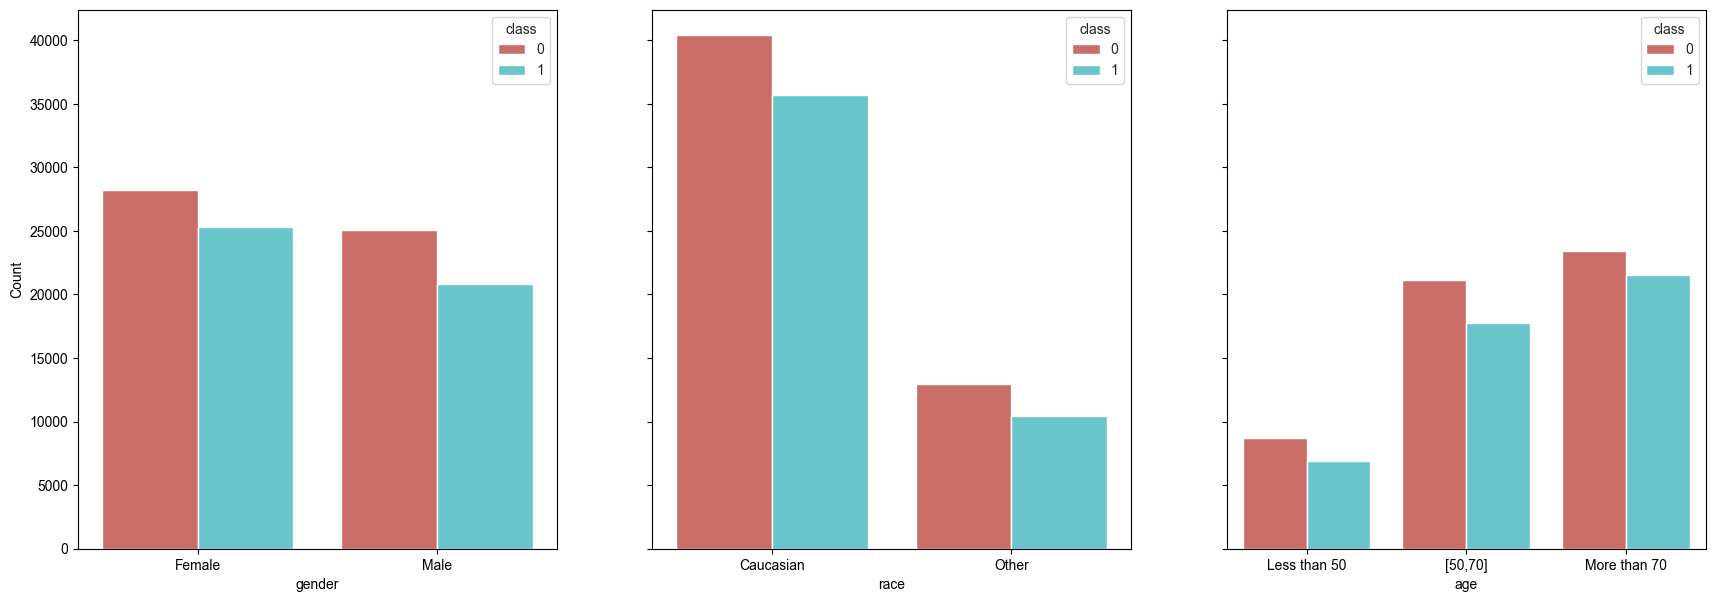

In [3]:
ml_ds = openml.datasets.get_dataset(45069)
df, * _ = ml_ds.get_data()

print(ml_ds.description[:700])
target = "class"
df[target] = df[target].replace('>30', 1)
df[target] = df[target].replace('<30', 1)
df[target] = df[target].replace('NO', 0)
protected_attributes = ["gender","race","age"]
df['gender'] = df['gender'].replace('Unknown/Invalid', pd.NA)

df['race'].replace('Unknown','Other',inplace=True)
df['race'].replace('Hispanic','Other',inplace=True)
df['race'].replace('Asian','Other',inplace=True)
df['race'].replace('AfricanAmerican','Other',inplace=True)

df['age'].replace("[70-80)","More than 70",inplace=True)
df['age'].replace("[80-90)","More than 70",inplace=True)
df['age'].replace("[90-100)","More than 70",inplace=True)

df['age'].replace("[60-70)","[50,70]",inplace=True)
df['age'].replace("[50-60)","[50,70]",inplace=True)

df['age'].replace("[40-50)","Less than 50",inplace=True)
df['age'].replace("[30-40)","Less than 50",inplace=True)
df['age'].replace("[20-30)", "Less than 50", inplace=True)
df['age'].replace("[10-20)","Less than 50",inplace=True)
df['age'].replace("[0-10)","Less than 50",inplace=True)

#df = df.dropna()  #dropping nans drops many race and gender entries from the unprotected groups. 
df = df.dropna(subset=['race'])
df = df.dropna(subset=['gender'])

nan_columns =df.columns[df.isna().any()].tolist()
df.drop(columns=nan_columns, inplace=True)

def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(4, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [16]:
df[target].value_counts()

class
0    53316
1    46176
Name: count, dtype: int64

In [4]:
# normalize data, convert to numerical
categorical_attributes = get_categorical_attributes(df)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and col != target:
        df_num[col] = scaler.fit_transform(df_num[[col]])

['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed']
Attribute: race
{'Caucasian': 0, 'Other': 1}
Attribute: gender
{'Female': 0, 'Male': 1}
Attribute: age
{'Less than 50': 0, 'More than 70': 1, '[50,70]': 2}
Attribute: max_glu_serum
{'>200': 0, '>300': 1, 'None': 2, 'Norm': 3}
Attribute: A1Cresult
{'>7': 0, '>8': 1, 'None': 2, 'Norm': 3}
Attribute: metformin
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: repaglinide
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: nateglinide
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: chlorpropamide
{'Down': 0, 'No': 1, 'St

In [5]:
'''
Top 3 protected attributes: gender, race, age. Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["gender/race"] = df_intersect["gender"].astype(str) + " " +  df_intersect["race"].astype(str)
df_intersect["gender/age"] = df_intersect["gender"].astype(str) + " " + df_intersect["age"].astype(str)
df_intersect["race/age"] = df_intersect["race"].astype(str) + " " + df_intersect["age"].astype(str)

df_intersect.drop(["race", "gender", "age"], axis=1, inplace=True)

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num_int.columns:
    if col not in categorical_attributes and col != target:
        df_num_int[col] = scaler.fit_transform(df_num_int[[col]])
protected_attributes_int = ["gender/race","gender/age","race/age"]

['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed', 'gender/race', 'gender/age', 'race/age']
Attribute: max_glu_serum
{'>200': 0, '>300': 1, 'None': 2, 'Norm': 3}
Attribute: A1Cresult
{'>7': 0, '>8': 1, 'None': 2, 'Norm': 3}
Attribute: metformin
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: repaglinide
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: nateglinide
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: chlorpropamide
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: glimepiride
{'Down': 0, 'No': 1, 'Steady': 2, 'Up': 3}
Attribute: acetohexamide
{'No': 0, 'Steady': 1}
Attribu

In [10]:
def split_and_train(data, attributes):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    models = {"Catboost",
                  "LogisticRegression",
                  "RandomForest",
                  "DecisionTree"
                  }
    y_predicted_dict = {}
    metrics_dict = {}
    for m in models:
            model = choose_model(m, x_train, y_train)
            y_predicted =  evaluate_model(model, x_train, x_test, y_train, y_test)
            attribute_metrics  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_predicted,attributes=attributes, target=target)
            metrics_dict[m] = attribute_metrics
            y_predicted_dict[m] = y_predicted
            print(f"Classification report for model: {model} : \n {classification_report(y_test, y_predicted)}")
            # plot_roc_curve(y_true=y_test, y_pred=y_predicted, model_name=m)
    return x_test, y_test, y_predicted_dict, metrics_dict

def plot_audit(dataset, attributes):
    audit = Audit(dataset[['score','label_value']+attributes])
    summary = audit.summary_plot(["tpr","fpr","fnr","tnr","for","fdr","pprev"])
    summary.show()

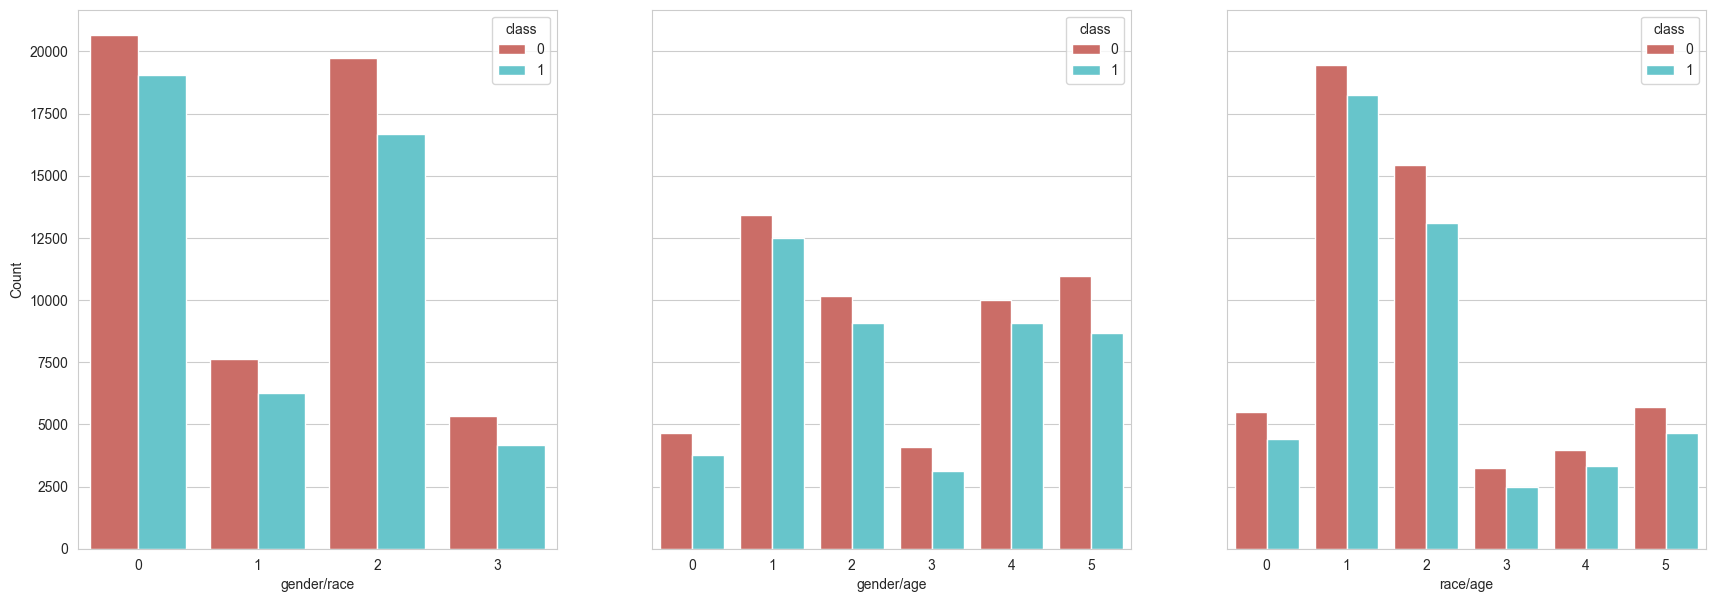

In [7]:
plot_attributes(df_num_int,protected_attributes_int)

In [8]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.6133
Accuracy score test:
0.6177
----------------------------------------

Privileged groups:  [{'gender': 0}]
Unprivileged groups:  [{'gender': 1}]
Disparate Impact Ratio for gender: 0.814
Statistical Parity Difference for gender: -0.060


Privileged groups:  [{'race': 0}]
Unprivileged groups:  [{'race': 1}]
Disparate Impact Ratio for race: 0.801
Statistical Parity Difference for race: -0.062


Privileged groups:  [{'age': 1}]
Unprivileged groups:  [{'age': 0}, {'age': 2}]
Disparate Impact Ratio for age: 0.880
Statistical Parity Difference for age: -0.038


Classification report for model: LogisticRegression(C=0.21, max_iter=200, random_state=42, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.61      0.80      0.69     13498
           1       0.63      0.41      0.49     11375

    accuracy                           0.62     24873
   macro avg       0

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender,0,0.63,0.47,0.77,0.37,0.36,0.23,0.53,0.63,0.64,0.56,0.34,0.47
1,gender,1,0.63,0.44,0.79,0.37,0.37,0.21,0.56,0.63,0.63,0.44,0.31,0.45
2,race,0,0.63,0.45,0.78,0.38,0.36,0.22,0.55,0.62,0.64,0.77,0.33,0.46
3,race,1,0.64,0.46,0.79,0.35,0.37,0.21,0.54,0.65,0.63,0.23,0.32,0.44
4,age,0,0.69,0.52,0.82,0.31,0.31,0.18,0.48,0.69,0.69,0.16,0.32,0.43
5,age,1,0.60,0.43,0.75,0.41,0.38,0.25,0.57,0.59,0.62,0.46,0.34,0.48
6,age,2,0.64,0.45,0.79,0.35,0.36,0.21,0.55,0.65,0.64,0.38,0.32,0.44


Majority class for:  gender  is: 0
Majority class for:  race  is: 0
Majority class for:  age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,False,False,True,True,True
1,gender,1,1.05,1.06,0.98,0.93,1.01,0.77,0.92,0.97,...,False,False,False,False,False,False,False,False,False,False
2,race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,False,False,True,True,True
3,race,1,1.02,0.99,0.92,0.94,1.05,0.30,0.97,0.99,...,False,False,False,False,False,False,False,False,False,False
4,age,0,0.81,0.85,0.76,0.72,1.16,0.34,0.97,1.12,...,True,True,True,True,True,False,False,True,True,True
5,age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,age,2,0.95,0.96,0.87,0.84,1.09,0.82,0.95,1.03,...,False,True,True,False,True,True,True,False,False,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age,False,True,True,False,False,True,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,gender,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,0,binary 0/1,race,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True


In [9]:
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['Catboost'], target, protected_attributes)


,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender,0,0.64,0.51,0.75,0.36,0.36,0.25,0.49,0.64,0.64,0.57,0.37,0.47
1,gender,1,0.64,0.47,0.78,0.36,0.37,0.22,0.53,0.64,0.63,0.43,0.33,0.45
2,race,0,0.64,0.50,0.76,0.36,0.36,0.24,0.50,0.64,0.64,0.78,0.36,0.46
3,race,1,0.65,0.47,0.79,0.34,0.36,0.21,0.53,0.66,0.64,0.22,0.32,0.44
4,age,0,0.69,0.51,0.83,0.31,0.30,0.17,0.49,0.69,0.70,0.14,0.32,0.43
5,age,1,0.61,0.49,0.72,0.39,0.38,0.28,0.51,0.61,0.62,0.49,0.38,0.48
6,age,2,0.65,0.48,0.78,0.34,0.36,0.22,0.52,0.66,0.64,0.37,0.34,0.44


Majority class for:  gender  is: 0
Majority class for:  race  is: 0
Majority class for:  age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,gender,1,1.03,1.09,0.99,0.89,1.01,0.75,0.89,0.98,...,False,False,False,False,False,False,False,False,False,False
2,race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
3,race,1,1.00,1.05,0.94,0.85,1.04,0.28,0.90,1.00,...,False,False,False,False,False,False,False,False,False,False
4,age,0,0.78,0.96,0.79,0.60,1.13,0.30,0.83,1.14,...,True,True,True,True,True,True,True,True,True,True
5,age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,age,2,0.94,1.02,0.88,0.78,1.08,0.76,0.88,1.04,...,False,True,True,False,True,True,True,False,False,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,gender,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,0,binary 0/1,race,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True


In [11]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['Catboost'], target, protected_attributes_int)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.6133
Accuracy score test:
0.6176
----------------------------------------

Privileged groups:  [{'gender/race': 0}]
Unprivileged groups:  [{'gender/race': 3}, {'gender/race': 1}, {'gender/race': 2}]
Disparate Impact Ratio for gender/race: 0.759
Statistical Parity Difference for gender/race: -0.084


Privileged groups:  [{'gender/age': 1}]
Unprivileged groups:  [{'gender/age': 3}, {'gender/age': 0}, {'gender/age': 5}, {'gender/age': 2}, {'gender/age': 4}]
Disparate Impact Ratio for gender/age: 0.823
Statistical Parity Difference for gender/age: -0.061


Privileged groups:  [{'race/age': 1}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 4}, {'race/age': 0}, {'race/age': 5}, {'race/age': 2}]
Disparate Impact Ratio for race/age: 0.845
Statistical Parity Difference for race/age: -0.051


Classification report for model: LogisticRegression(C=0.21, max_iter=200, random_state=42, solver='liblinear') : 
   

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender/race,0,0.64,0.53,0.73,0.37,0.36,0.27,0.47,0.63,0.64,0.44,0.39,0.47
1,gender/race,1,0.65,0.47,0.79,0.34,0.36,0.21,0.53,0.66,0.64,0.13,0.33,0.44
2,gender/race,2,0.63,0.47,0.77,0.36,0.37,0.23,0.53,0.64,0.63,0.34,0.34,0.45
3,gender/race,3,0.65,0.46,0.80,0.34,0.36,0.20,0.54,0.66,0.64,0.08,0.31,0.44
4,gender/age,0,0.70,0.55,0.82,0.31,0.29,0.18,0.45,0.69,0.71,0.08,0.34,0.44
5,gender/age,1,0.61,0.51,0.71,0.39,0.38,0.29,0.49,0.61,0.62,0.30,0.40,0.48
6,gender/age,2,0.65,0.51,0.77,0.34,0.36,0.23,0.49,0.66,0.64,0.19,0.36,0.45
7,gender/age,3,0.69,0.49,0.83,0.31,0.32,0.17,0.51,0.69,0.68,0.06,0.31,0.42
8,gender/age,4,0.61,0.48,0.73,0.39,0.39,0.27,0.52,0.61,0.61,0.19,0.37,0.47
9,gender/age,5,0.64,0.45,0.80,0.35,0.37,0.20,0.55,0.65,0.63,0.17,0.31,0.44


Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender/race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,gender/race,1,1.01,1.13,0.94,0.79,1.03,0.29,0.83,0.99,...,False,False,False,False,False,False,False,False,False,False
2,gender/race,2,1.04,1.14,0.99,0.86,1.01,0.77,0.86,0.98,...,False,True,True,False,True,True,True,False,False,True
3,gender/race,3,1.01,1.15,0.94,0.75,1.04,0.19,0.80,1.00,...,True,True,True,True,True,True,True,True,True,True
4,gender/age,0,0.75,0.93,0.78,0.60,1.15,0.28,0.85,1.15,...,True,True,True,True,True,True,True,True,True,True
5,gender/age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,gender/age,2,0.94,1.00,0.86,0.79,1.09,0.65,0.90,1.04,...,False,True,True,False,True,True,True,False,False,True
7,gender/age,3,0.84,1.04,0.78,0.58,1.14,0.22,0.77,1.10,...,True,True,True,True,True,True,True,True,True,True
8,gender/age,4,1.03,1.07,0.98,0.92,1.01,0.65,0.92,0.98,...,False,False,False,False,False,True,True,False,False,False
9,gender/age,5,0.97,1.13,0.89,0.69,1.07,0.58,0.77,1.02,...,False,True,True,False,True,True,True,False,False,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,gender/race,False,True,True,False,True,True,True,True,True,True,False,True,False,False,False
2,0,binary 0/1,race/age,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False


In [12]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m1 = pre_process_massaging(data_to_transform, "gender/race",target)
data_transformed_m1["gender/race"] = data_transformed_m1["gender/race"].astype(int)
data_transformed_m2 = pre_process_massaging(data_transformed_m1, "gender/age",target)
data_transformed_m2["gender/age"] = data_transformed_m2["gender/age"].astype(int)
data_transformed_m3= pre_process_massaging(data_transformed_m2, "race/age",target)
data_transformed_m3["race/age"] = data_transformed_m3["race/age"].astype(int)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m3,protected_attributes_int)
#calculate the fairness report
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["Catboost"],target,protected_attributes_int)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.6416
Accuracy score test:
0.6457
----------------------------------------

Privileged groups:  [{'gender/race': 0}]
Unprivileged groups:  [{'gender/race': 3}, {'gender/race': 1}, {'gender/race': 2}]
Disparate Impact Ratio for gender/race: 0.917
Statistical Parity Difference for gender/race: -0.030


Privileged groups:  [{'gender/age': 1}]
Unprivileged groups:  [{'gender/age': 3}, {'gender/age': 0}, {'gender/age': 5}, {'gender/age': 2}, {'gender/age': 4}]
Disparate Impact Ratio for gender/age: 0.913
Statistical Parity Difference for gender/age: -0.032


Privileged groups:  [{'race/age': 1}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 4}, {'race/age': 0}, {'race/age': 5}, {'race/age': 2}]
Disparate Impact Ratio for race/age: 0.912
Statistical Parity Difference for race/age: -0.032


Classification report for model: LogisticRegression(C=0.21, max_iter=200, random_state=42, solver='liblinear') : 
   

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender/race,0,0.66,0.54,0.77,0.34,0.34,0.23,0.46,0.66,0.66,0.42,0.38,0.46
1,gender/race,1,0.69,0.54,0.81,0.32,0.29,0.19,0.46,0.68,0.71,0.14,0.35,0.45
2,gender/race,2,0.65,0.50,0.79,0.35,0.34,0.21,0.50,0.65,0.66,0.35,0.34,0.45
3,gender/race,3,0.68,0.53,0.81,0.32,0.31,0.19,0.47,0.68,0.69,0.09,0.34,0.45
4,gender/age,0,0.74,0.60,0.85,0.29,0.22,0.15,0.40,0.71,0.78,0.09,0.36,0.46
5,gender/age,1,0.63,0.51,0.74,0.37,0.37,0.26,0.49,0.63,0.63,0.28,0.37,0.47
6,gender/age,2,0.69,0.56,0.79,0.31,0.31,0.21,0.44,0.69,0.69,0.20,0.37,0.45
7,gender/age,3,0.70,0.52,0.85,0.32,0.26,0.15,0.48,0.68,0.74,0.06,0.31,0.45
8,gender/age,4,0.64,0.50,0.75,0.36,0.36,0.25,0.50,0.64,0.64,0.19,0.37,0.46
9,gender/age,5,0.67,0.50,0.80,0.34,0.33,0.20,0.50,0.66,0.67,0.18,0.33,0.45


Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender/race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,gender/race,1,0.88,1.01,0.95,0.80,1.03,0.32,0.92,1.06,...,False,False,False,False,False,False,False,False,False,False
2,gender/race,2,1.01,1.10,1.03,0.90,0.99,0.81,0.90,0.99,...,True,True,True,True,True,True,True,True,True,True
3,gender/race,3,0.93,1.03,0.96,0.83,1.02,0.22,0.91,1.04,...,True,True,True,True,True,True,True,True,True,True
4,gender/age,0,0.60,0.81,0.78,0.57,1.12,0.31,0.96,1.23,...,True,True,True,True,True,True,True,True,True,True
5,gender/age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,gender/age,2,0.85,0.90,0.86,0.81,1.08,0.72,0.98,1.09,...,True,True,True,True,True,True,True,True,True,True
7,gender/age,3,0.70,0.99,0.87,0.57,1.07,0.23,0.83,1.18,...,True,True,True,True,True,True,True,True,True,True
8,gender/age,4,0.99,1.01,0.99,0.96,1.00,0.69,0.97,1.01,...,True,False,False,True,False,False,False,True,True,False
9,gender/age,5,0.90,1.03,0.92,0.77,1.05,0.66,0.88,1.06,...,True,True,True,True,True,True,True,True,True,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,gender/race,False,True,True,False,True,True,True,True,True,True,False,True,False,False,False
2,0,binary 0/1,race/age,False,True,False,False,True,True,True,True,True,True,False,True,False,False,False


In [13]:
# compare disparities to the original dataset
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed, protected_attributes_int)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [17]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps1 = pre_process_prev_sampling(data_to_transform, "gender/race",target)
data_transformed_ps1["gender/race"] = data_transformed_ps1["gender/race"].astype(int)
data_transformed_ps2 = pre_process_prev_sampling(data_transformed_ps1, "gender/age",target)
data_transformed_ps2["gender/age"] = data_transformed_ps2["gender/age"].astype(int)
data_transformed_ps3= pre_process_prev_sampling(data_transformed_ps2, "race/age",target)
data_transformed_ps3["race/age"] = data_transformed_ps3["race/age"].astype(int)

#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps3,protected_attributes_int)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["Catboost"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

[INFO] 2024-09-09 11:58:08 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-09 11:58:08 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-09 11:58:08 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-09 11:58:08 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-09 11:58:08 methods.preprocessing.PrevalenceSampling - Original group 1 size: 13886


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 13886


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 1 size: 13510


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 13510


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 0 size: 39689


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 39689


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 0 size: 38518


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 38518


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 2 size: 36410


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 36410


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 2 size: 35913


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 35913


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 3 size: 9507


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 9507


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 3 size: 9028


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 9028


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 2 size: 18714


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 18714


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 2 size: 18709


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 18709


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 1 size: 25163


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 25163


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 1 size: 24836


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 24836


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 0 size: 8151


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 8151


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 0 size: 7767


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 7767


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 5 size: 19189


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 19189


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 5 size: 18674


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 18674


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 4 size: 18728


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 18728


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 4 size: 18015


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 18015


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 3 size: 7024


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 7024


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 3 size: 6716


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 6716


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 5 size: 9851


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 9851


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 5 size: 9720


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 9720


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 2 size: 27532


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 27532


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 2 size: 27381


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 27381


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 4 size: 6918


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 6918


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 4 size: 6882


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 6882


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 3 size: 5259


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 5259


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 3 size: 5193


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 5193


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 1 size: 35933


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 35933


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 1 size: 35902


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 35902


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Original group 0 size: 9224


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 9224


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Final group 0 size: 9149


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 9149


[INFO] 2024-09-09 11:58:09 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.6140
Accuracy score test:
0.6123
----------------------------------------

Privileged groups:  [{'gender/race': 0}]
Unprivileged groups:  [{'gender/race': 3}, {'gender/race': 1}, {'gender/race': 2}]
Disparate Impact Ratio for gender/race: 0.978
Statistical Parity Difference for gender/race: -0.006


Privileged groups:  [{'gender/age': 1}]
Unprivileged groups:  [{'gender/age': 3}, {'gender/age': 0}, {'gender/age': 5}, {'gender/age': 2}, {'gender/age': 4}]
Disparate Impact Ratio for gender/age: 1.010
Statistical Parity Difference for gender/age: 0.003


Privileged groups:  [{'race/age': 1}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 4}, {'race/age': 0}, {'race/age': 5}, {'race/age': 2}]
Disparate Impact Ratio for race/age: 0.931
Statistical Parity Difference for race/age: -0.021


Classification report for model: LogisticRegression(C=0.21, max_iter=200, random_state=42, solver='liblinear') : 
    

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender/race,0,0.64,0.50,0.76,0.37,0.35,0.24,0.50,0.63,0.65,0.41,0.36,0.47
1,gender/race,1,0.63,0.47,0.78,0.38,0.35,0.22,0.53,0.62,0.65,0.13,0.34,0.47
2,gender/race,2,0.63,0.47,0.77,0.37,0.37,0.23,0.53,0.63,0.63,0.36,0.34,0.46
3,gender/race,3,0.64,0.46,0.78,0.36,0.36,0.22,0.54,0.64,0.64,0.09,0.33,0.46
4,gender/age,0,0.69,0.55,0.82,0.33,0.27,0.18,0.45,0.67,0.73,0.08,0.35,0.47
5,gender/age,1,0.61,0.47,0.74,0.39,0.39,0.26,0.53,0.61,0.61,0.27,0.36,0.47
6,gender/age,2,0.65,0.50,0.78,0.37,0.33,0.22,0.50,0.63,0.67,0.20,0.35,0.47
7,gender/age,3,0.67,0.50,0.81,0.34,0.31,0.19,0.50,0.66,0.69,0.07,0.33,0.45
8,gender/age,4,0.61,0.47,0.73,0.39,0.40,0.27,0.53,0.61,0.60,0.20,0.36,0.47
9,gender/age,5,0.64,0.46,0.79,0.37,0.35,0.21,0.54,0.63,0.65,0.18,0.33,0.46


Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender/race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,False,False,True,True,True
1,gender/race,1,0.98,1.06,1.04,0.94,0.98,0.32,0.94,1.01,...,False,False,False,False,False,False,False,False,False,False
2,gender/race,2,1.04,1.05,1.01,0.98,0.99,0.88,0.95,0.98,...,True,False,False,True,False,True,True,True,True,False
3,gender/race,3,1.02,1.07,0.99,0.91,1.01,0.21,0.91,0.99,...,True,True,True,True,True,True,True,True,True,True
4,gender/age,0,0.69,0.85,0.85,0.68,1.10,0.30,0.98,1.20,...,True,True,True,True,True,False,False,True,True,True
5,gender/age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,gender/age,2,0.84,0.95,0.95,0.83,1.03,0.73,0.97,1.11,...,True,False,False,True,False,True,True,True,True,False
7,gender/age,3,0.80,0.94,0.87,0.72,1.08,0.25,0.92,1.13,...,True,True,True,True,True,True,True,True,True,True
8,gender/age,4,1.01,1.00,1.01,1.01,1.00,0.74,1.00,0.99,...,False,False,False,False,False,True,True,False,False,False
9,gender/age,5,0.90,1.02,0.95,0.80,1.03,0.68,0.91,1.06,...,True,False,False,True,False,True,True,True,True,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,True,True,True,True,True,True,False,True,False,False,False
1,0,binary 0/1,gender/race,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,0,binary 0/1,race/age,False,True,False,False,True,True,True,True,True,True,False,True,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [14]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
columns_to_change = df_num_int.columns.difference(protected_attributes_int).tolist()
columns_to_change.remove(target)
data_transformed_dr1 = pre_process_data_repairer(data_to_transform, 'gender/race',target,columns_to_change)
data_transformed_dr2 = pre_process_data_repairer(data_transformed_dr1, 'gender/age',target,columns_to_change)
data_transformed_dr3 = pre_process_data_repairer(data_transformed_dr2, 'race/age',target,columns_to_change)
data_transformed_dr3['gender/race'] = data_transformed_dr3['gender/race'].astype(int)
data_transformed_dr3['gender/age'] = data_transformed_dr3['gender/age'].astype(int)
data_transformed_dr3['race/age'] = data_transformed_dr3['race/age'].astype(int)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr3,protected_attributes_int)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["RandomForest"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)


---------- Model name:  RandomForest ----------

Accuracy score training:
0.6232
Accuracy score test:
0.6240
----------------------------------------

Privileged groups:  [{'gender/race': 0}]
Unprivileged groups:  [{'gender/race': 3}, {'gender/race': 1}, {'gender/race': 2}]
Disparate Impact Ratio for gender/race: 0.931
Statistical Parity Difference for gender/race: -0.024


Privileged groups:  [{'gender/age': 1}]
Unprivileged groups:  [{'gender/age': 3}, {'gender/age': 0}, {'gender/age': 5}, {'gender/age': 2}, {'gender/age': 4}]
Disparate Impact Ratio for gender/age: 0.930
Statistical Parity Difference for gender/age: -0.025


Privileged groups:  [{'race/age': 1}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 4}, {'race/age': 0}, {'race/age': 5}, {'race/age': 2}]
Disparate Impact Ratio for race/age: 0.945
Statistical Parity Difference for race/age: -0.019


Classification report for model: RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators=500) : 
            

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender/race,0,0.62,0.47,0.76,0.39,0.36,0.24,0.53,0.61,0.64,0.42,0.35,0.47
1,gender/race,1,0.64,0.47,0.77,0.35,0.38,0.23,0.53,0.65,0.62,0.14,0.33,0.44
2,gender/race,2,0.62,0.43,0.77,0.38,0.39,0.23,0.57,0.62,0.61,0.34,0.32,0.45
3,gender/race,3,0.64,0.48,0.77,0.34,0.38,0.23,0.52,0.66,0.62,0.10,0.34,0.44
4,gender/age,0,0.69,0.53,0.83,0.31,0.29,0.17,0.47,0.69,0.71,0.09,0.33,0.44
5,gender/age,1,0.59,0.44,0.73,0.42,0.40,0.27,0.56,0.58,0.60,0.28,0.35,0.48
6,gender/age,2,0.64,0.48,0.77,0.35,0.37,0.23,0.52,0.65,0.63,0.20,0.34,0.45
7,gender/age,3,0.68,0.51,0.80,0.31,0.35,0.20,0.49,0.69,0.65,0.07,0.33,0.42
8,gender/age,4,0.59,0.42,0.74,0.41,0.41,0.26,0.58,0.59,0.59,0.19,0.34,0.47
9,gender/age,5,0.63,0.43,0.79,0.36,0.39,0.21,0.57,0.64,0.61,0.18,0.31,0.44


Majority class for:  gender/race  is: 0
Majority class for:  gender/age  is: 1
Majority class for:  race/age  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender/race,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,False,False,True,True,True
1,gender/race,1,1.04,1.00,0.90,0.93,1.06,0.33,0.95,0.98,...,False,False,False,False,False,False,False,False,False,False
2,gender/race,2,1.08,1.07,0.98,0.94,1.02,0.82,0.91,0.96,...,True,True,True,True,True,True,True,True,True,True
3,gender/race,3,1.05,0.98,0.89,0.95,1.07,0.23,0.97,0.97,...,True,True,True,True,True,False,False,True,True,True
4,gender/age,0,0.73,0.84,0.75,0.64,1.18,0.31,0.94,1.17,...,True,True,True,True,True,False,False,True,True,True
5,gender/age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,gender/age,2,0.92,0.93,0.84,0.83,1.11,0.70,0.96,1.05,...,True,True,True,True,True,True,True,True,True,True
7,gender/age,3,0.88,0.88,0.74,0.73,1.19,0.26,0.93,1.08,...,True,True,True,True,True,False,False,True,True,True
8,gender/age,4,1.05,1.03,0.98,0.97,1.02,0.68,0.96,0.97,...,False,False,False,False,False,False,False,False,False,False
9,gender/age,5,0.97,1.02,0.86,0.77,1.10,0.65,0.87,1.02,...,False,True,True,False,True,False,False,False,False,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/age,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,gender/race,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,0,binary 0/1,race/age,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [15]:

from aequitas.flow.methods.inprocessing import FairlearnClassifier

'''
In-processing: Fair learn classifier 
'''


def train_with_fairlearn(data, attribute, model, metrics_dict):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    s_train = x_train[attribute]
    x_train = x_train.drop(columns=[attribute], axis=1)
    s_test = x_test[attribute]
    x_test = x_test.drop(columns=[attribute], axis=1)

    fairlearn_clf = FairlearnClassifier(estimator=model, constraint="fairlearn.reductions.DemographicParity",
                                        reduction='fairlearn.reductions.ExponentiatedGradient')

    fairlearn_clf.fit(x_train, y_train, s_train)
    y_train_pred = fairlearn_clf.predict_proba(x_train, s_train).astype(int)
    y_test_pred = fairlearn_clf.predict_proba(x_test, s_test).astype(int)
    x_test.insert(len(x_test.columns) - 1, attribute, s_test, True)  # insert back the attribute
    print("Model:\n", model)
    print(f"Accuracy score training:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Accuracy score test:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification report for model: {model} : \n {classification_report(y_test, y_test_pred)}")
    metric = calc_metrics(x_test=x_test, y_test=y_test, y_predicted=y_test_pred, attributes=[attribute], target=target)
    metrics_dict[model] = metric
    return x_test, y_test, y_test_pred, metrics_dict


data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl = train_with_fairlearn(data_to_transform, "gender/age",
                                                                             models[0], metrics_dict)

[INFO] 2024-09-05 16:02:48 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-09-05 16:02:48 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


[INFO] 2024-09-05 16:02:48 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.ensemble.RandomForestClassifier
Accuracy score training:
0.9999
Accuracy score test:
0.6269
Classification report for model: sklearn.ensemble.RandomForestClassifier : 
               precision    recall  f1-score   support

           0       0.62      0.78      0.69     10633
           1       0.64      0.45      0.53      9266

    accuracy                           0.63     19899
   macro avg       0.63      0.62      0.61     19899
weighted avg       0.63      0.63      0.62     19899

Privileged groups:  [{'gender/age': 1}]
Unprivileged groups:  [{'gender/age': 3}, {'gender/age': 0}, {'gender/age': 5}, {'gender/age': 2}, {'gender/age': 4}]
Disparate Impact Ratio for gender/age: 0.951
Statistical Parity Difference for gender/age: -0.017


